# Processing data

In [621]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import cross_val_predict

In [622]:
url = r"..\data\raw\clean_house.csv"
house = pd.read_csv(url, sep=",")

## subsetting columns and rows

In [623]:
house.head(5)

,property_id,locality_name,postal_code,latitude,longitude,property_type,property_subtype,price,type_of_sale,number_of_rooms,...,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,swimming_pool,state_of_building,main_city,province
0,11157483,ronse,9600,50.741809,3.607601,HOUSE,HOUSE,245000.0,BUY_REGULAR,NaN,...,1.0,13.0,1.0,161.0,250.0,2.0,0.0,GOOD,ronse,oost-vlaanderen
1,11156843,merelbeke,9820,51.019250,3.760957,HOUSE,HOUSE,315000.0,BUY_REGULAR,NaN,...,1.0,23.0,NaN,NaN,77.0,2.0,NaN,GOOD,merelbeke,oost-vlaanderen
2,11161362,forêt,4870,50.563966,5.675489,HOUSE,HOUSE,325000.0,BUY_REGULAR,NaN,...,1.0,16.0,1.0,420.0,572.0,3.0,NaN,AS_NEW,trooz,luik
3,11153591,ottignies,1340,50.671784,4.575929,HOUSE,HOUSE,395000.0,BUY_REGULAR,NaN,...,1.0,37.0,1.0,76.0,165.0,2.0,NaN,GOOD,ottignies-louvain-la-neuve,waals-brabant
4,11128275,antwerpen merksem,2170,51.243743,4.443372,HOUSE,MIXED_USE_BUILDING,399900.0,BUY_REGULAR,NaN,...,NaN,NaN,NaN,NaN,65.0,2.0,0.0,GOOD,antwerpen,antwerpen


In [624]:
def replace_outliers(df, columns):
    for column in columns:
    # Outliers handling
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        max_value = Q3 + (1.5 * IQR)
        min_value = Q1 - (1.5 * IQR)

        outliers_mask = (df[column] < min_value) | (df[column] > max_value)
        df.loc[outliers_mask, column] = np.nan

        df.dropna(subset=[column], inplace=True)
    return df

In [625]:
lcolm = ["price", "surface_of_good"]
house = replace_outliers(house,lcolm)

In [626]:
house['postal_code'] = house['postal_code'].astype(str).str[:2]

## drop columns

In [627]:
def drop_columns(df, clist):
    ndf = df.drop(columns=clist)
    return ndf


In [628]:
todropcolumns = ["property_id", "locality_name", "latitude", "longitude", "property_type", "type_of_sale", "main_city", "province"]
nhouse = drop_columns(house, todropcolumns)

In [629]:

# dropping the NaN values in the columns selected
def droping_null(df, colist):
    df.dropna(subset=colist, inplace=True)
    return df



## transform categorical data to numerical data

In [630]:
def transform_categorical2(df, clist):
    for column in clist:
        # One-hot encode the current column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_ohe = ohe.fit_transform(df[[column]])
        
        # Convert the one-hot encoded features to a DataFrame
        ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
        df = pd.concat([df, ohe_df], axis=1)
        
        # Drop the original categorical column
        df.drop(columns=[column], inplace=True)

    return df

In [631]:
def tranform_label_encoder(df, clist):
    for column in clist:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df



In [632]:
def select_best(df, clistColumns, predict, k):
    sk = SelectKBest(chi2, k=k)
    sk.fit(df[clistColumns], df[predict])
    selected_columns = df.columns[sk.get_support()]
    return df[selected_columns]

    

In [633]:
clist = ["state_of_building", "property_subtype"]
plist = ["kitchen_type", "postal_code"]
chouse = transform_categorical2(nhouse, plist)
chouse = tranform_label_encoder(chouse, clist)
chouse = droping_null(chouse, "terrace")
chouse = droping_null(chouse, "garden")

## Make the training set and test set

In [634]:
def create_X_y(df, Y):
    X = df.drop(columns=[Y])
    y = df[[Y]]
    return X, y




In [635]:
X, y = create_X_y(chouse, "price")

In [636]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=40 )

## Imputation on the X_train, X_test

In [637]:
X_test.shape
X_train.shape 

(2225, 104)

In [638]:
X_train.head(5)

,property_subtype,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
8283,9,NaN,262.0,1.0,0.0,0.0,1.0,NaN,1.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,6,NaN,202.0,1.0,NaN,0.0,1.0,10.0,1.0,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044,6,NaN,90.0,1.0,0.0,0.0,1.0,38.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10664,6,NaN,145.0,1.0,NaN,1.0,1.0,14.0,1.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5618,6,NaN,219.0,1.0,0.0,0.0,1.0,14.0,1.0,400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [639]:
def replace_NaN_Categorical(df, comlist):
    df[comlist] = df[comlist].fillna(0.0)
    

In [640]:
X_train = drop_columns(X_train, ["furnished", "number_of_rooms"])
X_test = drop_columns(X_test, ["furnished", "number_of_rooms"])

In [641]:
def change_to_int(df, columnsname):
    for column in columnsname:
        df[column] = df[column].round().astype(int)
    return df


In [642]:
def replace_null_median(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].median()
    return df

In [643]:
def replace_null_mean(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].mean()
    return df

In [644]:
def replace_null_to_zero(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = 0
    return df

### replacing values

In [645]:
X_train = replace_null_mean(X_train, ["terrace_area", "garden_area"])
X_train = replace_null_median(X_train, ["fully_equipped_kitchen", "number_of_facades"])
X_train = replace_null_to_zero(X_train, ["swimming_pool"])

X_test = replace_null_mean(X_test, ["terrace_area", "garden_area"])
X_test = replace_null_median(X_test, ["fully_equipped_kitchen", "number_of_facades"])
X_test = replace_null_to_zero(X_test, ["swimming_pool"])

In [646]:
X_train = change_to_int(X_train, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])
X_test = change_to_int(X_test, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])

In [647]:
y_test = replace_null_mean(y_test, ["price"])
y_train = replace_null_mean(y_train, ["price"])

In [648]:
columns_with_null = X_train.columns[X_train.isnull().any()].tolist()
X_train = replace_null_to_zero(X_train, columns_with_null)
X_test = replace_null_to_zero(X_test, columns_with_null)

### scaling values

In [649]:
def scaling(df, cl):
    for column in cl:
        scaler = StandardScaler()
        #Fit and transform the data
        df[column] = scaler.fit_transform(df[[column]])
    return df

In [650]:
numerical_columns = ['living_area', 'terrace_area', 'garden_area', 'surface_of_good']
#X_test = scaling(X_test, numerical_columns)
#X_train = scaling(X_train, numerical_columns)

### testing the model

In [651]:
X_train.isnull().sum(), len(X_train)

(property_subtype          0
 living_area               0
 fully_equipped_kitchen    0
 open_fire                 0
 terrace                   0
                          ..
 postal_code_96            0
 postal_code_97            0
 postal_code_98            0
 postal_code_99            0
 postal_code_nan           0
 Length: 102, dtype: int64,
 2225)

In [652]:
y_test.isnull().sum()

price    0
dtype: int64

In [653]:
X_train.head()

,property_subtype,living_area,fully_equipped_kitchen,open_fire,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
8283,9,262.0,1,0.0,1.0,29.064634,1.0,25.000000,100.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1918,6,202.0,1,0.0,1.0,10.000000,1.0,130.000000,411.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044,6,90.0,1,0.0,1.0,38.000000,1.0,325.143154,139.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10664,6,145.0,1,1.0,1.0,14.000000,1.0,33.000000,110.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5618,6,219.0,1,0.0,1.0,14.000000,1.0,400.000000,800.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## scaling

In [654]:
#scaler = StandardScaler()
#scaler.fit(X_train)

# Transform both training and test data using the scaler fitted on training data
#X_train_std = scaler.transform(X_train)
#X_test_std = scaler.transform(X_test)

## testing model

In [655]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [656]:
regressor.fit(X_train, y_train).predict(X_test)


array([[ 2.87963312e+05],
       [ 3.72964875e+05],
       [ 2.85433438e+05],
       [ 4.83285375e+05],
       [ 5.85928688e+05],
       [ 3.69741062e+05],
       [ 4.05477188e+05],
       [ 3.76608125e+05],
       [ 4.10741250e+05],
       [ 5.84100500e+05],
       [ 5.97711812e+05],
       [ 3.00313125e+05],
       [ 5.69100500e+05],
       [ 3.44177125e+05],
       [ 3.60926312e+05],
       [ 4.02957438e+05],
       [ 6.86574188e+05],
       [ 3.24032938e+05],
       [ 3.35153188e+05],
       [ 3.25319875e+05],
       [ 4.79719250e+05],
       [ 5.03767500e+05],
       [ 3.15712438e+05],
       [ 3.29187562e+05],
       [ 4.14127438e+05],
       [ 3.97308688e+05],
       [ 4.38545875e+05],
       [ 5.21783000e+05],
       [ 6.22861938e+05],
       [ 2.13461750e+05],
       [ 3.34397062e+05],
       [ 5.31838875e+05],
       [ 3.98470000e+05],
       [ 5.83256375e+05],
       [ 3.95927688e+05],
       [ 2.58923938e+05],
       [ 1.88391562e+05],
       [ 5.79953625e+05],
       [ 3.5

In [657]:
regressor.score(X_train, y_train)

0.3800250373181958

In [658]:
y_pred = regressor.predict(X_train)
score = r2_score(y_train, y_pred)
score

0.3800250373181958

In [659]:
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)
score

-3652493598.162629

## Cross validation

In [660]:
cv_pred = cross_val_predict(estimator=regressor, X=X_train, y=y_train, cv = 5)
#print("CV scores:", scores)
#print("mean score", scores.mean())
#print("std", scores.std())


In [661]:
print("Accuracy score:", r2_score(y_true=y_train, y_pred=cv_pred))

Accuracy score: -27531410.867455114


## Plotting the result

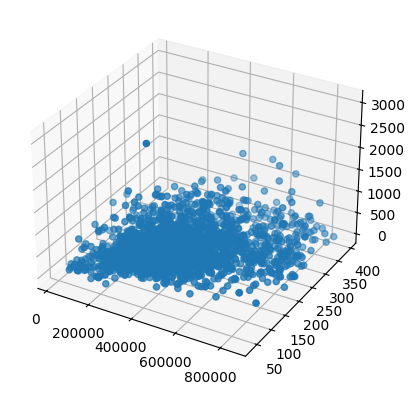

In [662]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train['price'], X_train['living_area'], X_train['garden_area'])